### Optuna, bayesian hyperparam optimization analyis

In this notebook, we will compare the results of choosing different objective functions for hyper-param tunning. Also we present the results of adding the EM cells to the whole dataset. 

In [4]:
# From python
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score

# From cplAE_MET
from cplAE_MET.utils.plots import plot_z_3d, plot_m
from cplAE_MET.utils.optuna_helpers import load_study
from cplAE_MET.utils.analysis_helpers import load_exp_output
from cplAE_MET.utils.analysis_helpers import get_Leiden_comms
from cplAE_MET.utils.analysis_helpers import get_LDA_classification
from cplAE_MET.utils.analysis_helpers import summary_classification_results
from cplAE_MET.utils.optuna_helpers import summarize_optuna
# from cplAE_MET.models.bayesian_optimization import Leiden_community_detection
# from cplAE_MET.utils.analysis_helpers import get_communities_sorted_node_labels
from cplAE_MET.utils.analysis_helpers import summary_leiden_comm_silhouette_score
from cplAE_MET.utils.analysis_helpers import summarize_platforms

# From optuna
from optuna.visualization import plot_parallel_coordinate

/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'wurlitzer', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


#### Dataset overview:
We have Patchseq, ME, EM and fMOST cells.

In [5]:
summary = summarize_platforms("exc_inh_ME_fMOST_EM_specimen_ids_13Mar23.txt")
print(tabulate(summary, headers = 'keys', tablefmt = 'psql'))
print("Total numebr of cells: ", summary['total'].sum())

+----+------------+-----+------+-----+-------+-------+-------+---------+---------+
|    | platform   |   T |    E |   M |   E&T |   M&T |   M&E |   M&E&T |   total |
|----+------------+-----+------+-----+-------+-------+-------+---------+---------|
|  0 | patchseq   | 554 |    0 |   2 |  4441 |   102 |    58 |    1413 |    6570 |
|  1 | ME         |   0 | 1485 |   3 |     0 |     0 |   444 |       0 |    1932 |
|  2 | EM         |   0 |    0 | 479 |     0 |     0 |     0 |       0 |     479 |
|  3 | fMOST      |   0 |    0 | 280 |     0 |     0 |     0 |       0 |     280 |
+----+------------+-----+------+-----+-------+-------+-------+---------+---------+
Total numebr of cells:  9261


In [6]:
# experiments
exp = {}
exp["9000cells_classification_at50"] = "MET_patch_ME_EM_fMOST_merged_t_type_at50_classification_optimization_v1"
exp["8000cells_classification_at50"] = "MET_merged_t_type_at50_classification_optimization_v1"
exp["8000cells_classification_atleaf"] = "Optuna_T_ME_classification_obj_10000ep_10trial"
exp["8000cells_community_det"] = "optuna_all_connected_objective_comm_det_10trial_2000epochs_1000runs"

# Optimization studies to compare
study = {}
study["9000cells_classification_at50"] = load_study(exp["9000cells_classification_at50"])
study["8000cells_classification_at50"] = load_study(exp["8000cells_classification_at50"])
study["8000cells_classification_atleaf"] = load_study(exp["8000cells_classification_atleaf"])
study["8000cells_community_det"] = load_study(exp["8000cells_community_det"])

[I 2023-03-20 16:54:55,239] Using an existing study with name 'MET_patch_ME_EM_fMOST_merged_t_type_at50_classification_optimization_v1' instead of creating a new one.
[I 2023-03-20 16:54:55,292] Using an existing study with name 'MET_merged_t_type_at50_classification_optimization_v1' instead of creating a new one.
[I 2023-03-20 16:54:55,344] Using an existing study with name 'Optuna_T_ME_classification_obj_10000ep_10trial' instead of creating a new one.
[I 2023-03-20 16:54:55,392] Using an existing study with name 'optuna_all_connected_objective_comm_det_10trial_2000epochs_1000runs' instead of creating a new one.


In [7]:
for k, v in study.items():
    print()
    print("===================================================")
    print(k)
    summarize_optuna(v, True)


9000cells_classification_at50
Number of trials performed:  2000
Best trial number:  671
Best trial value:  68.8

Exp values of the best hyperparams
.........................................
lambda_tune_E_M 0.15485413471311713
lambda_tune_E_ME 0.02070378451862218
lambda_tune_E_T 0.013293732252632116
lambda_tune_ME_E 3.513420565631583
lambda_tune_ME_M 10.695829236468459
lambda_tune_ME_T 0.10589325172008282
lambda_tune_M_E 0.18916974700860623
lambda_tune_M_ME 0.013988524170279532
lambda_tune_M_T 0.020905365726493836
lambda_tune_T_E 40.00879343978866
lambda_tune_T_M 2.8432158928960343
lambda_tune_T_ME 25.02049972173

8000cells_classification_at50
Number of trials performed:  2940
Best trial number:  976
Best trial value:  68.8

Exp values of the best hyperparams
.........................................
lambda_tune_E_M 2.286541914836064
lambda_tune_E_ME 0.022972086486740234
lambda_tune_E_T 0.02411720491209806
lambda_tune_ME_E 4.79671632351618
lambda_tune_ME_M 3.995978118130145
lambda_tune

#### Optimizing classification acc for ~50 merged t_types and ~9000 cells 

In [8]:
plot_parallel_coordinate(study["9000cells_classification_at50"])

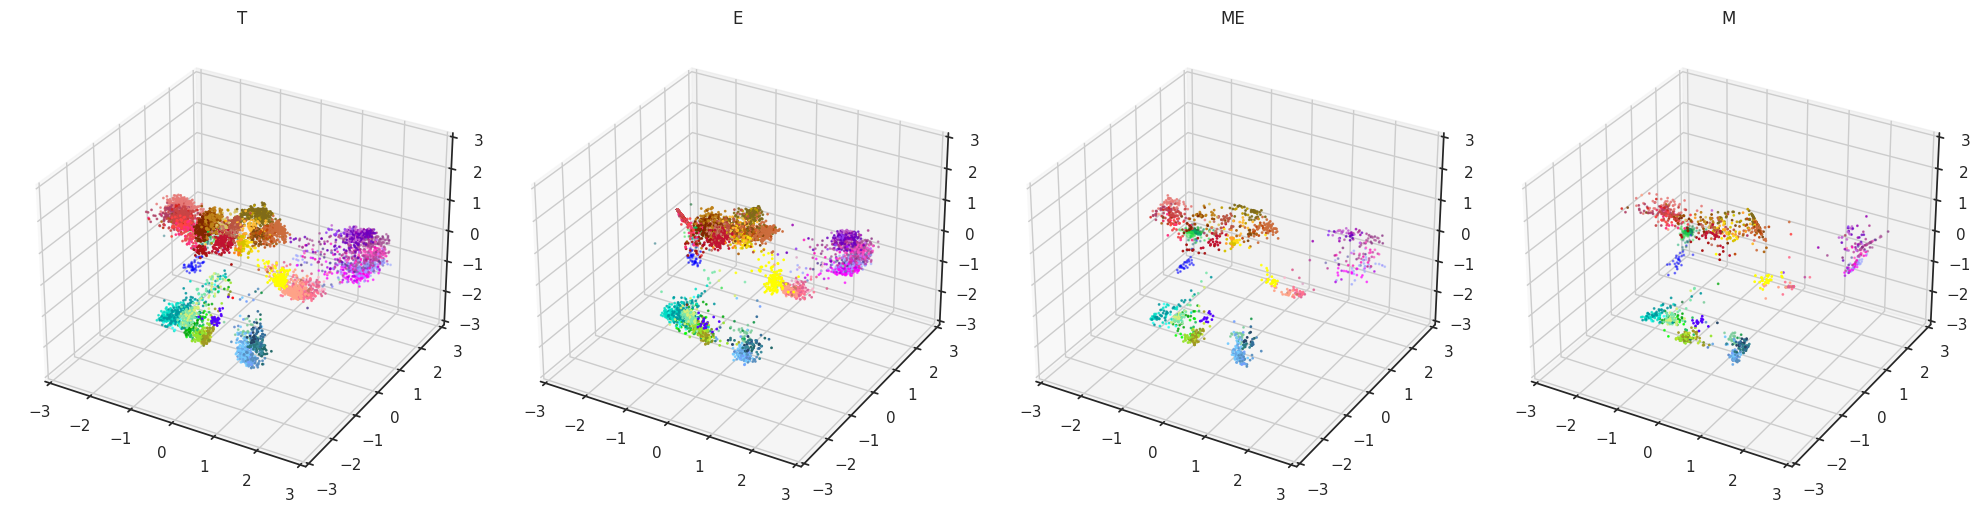

Leiden communities:
+----+----------+-----------+------------+-----------+
|    |   t_comm |   et_comm |   met_comm |   mt_comm |
|----+----------+-----------+------------+-----------|
|  0 |       26 |       307 |         22 |        27 |
+----+----------+-----------+------------+-----------+
10fold cross_validated Classification acc at different levels:
+----+--------------+----------------+-----------------+----------------+
|    |   t_clusters |   et_class_acc |   met_class_acc |   mt_class_acc |
|----+--------------+----------------+-----------------+----------------|
|  0 |           93 |          45.36 |           53.96 |          45.02 |
|  0 |           59 |          64.57 |           76.82 |          68.18 |
|  0 |           50 |          68.1  |           83.62 |          74.15 |
+----+--------------+----------------+-----------------+----------------+
Leiden communitie silhouette score:
+----+---------------+----------------+-----------------+----------------+
|    |   sil_

In [9]:
output = load_exp_output(exp_name=exp["9000cells_classification_at50"], pkl_file="Results_trial_671.pkl")
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))
print("Leiden communities:")
print(tabulate(get_Leiden_comms(output), headers = 'keys', tablefmt = 'psql'))
print("10fold cross_validated Classification acc at different levels:")
print(tabulate(summary_classification_results(output), headers = 'keys', tablefmt = 'psql'))
print("Leiden communitie silhouette score:")
print(tabulate(summary_leiden_comm_silhouette_score(output), headers = 'keys', tablefmt = 'psql'))

#### Optimizing classification acc for ~50 merged t_types and ~8000 cells 

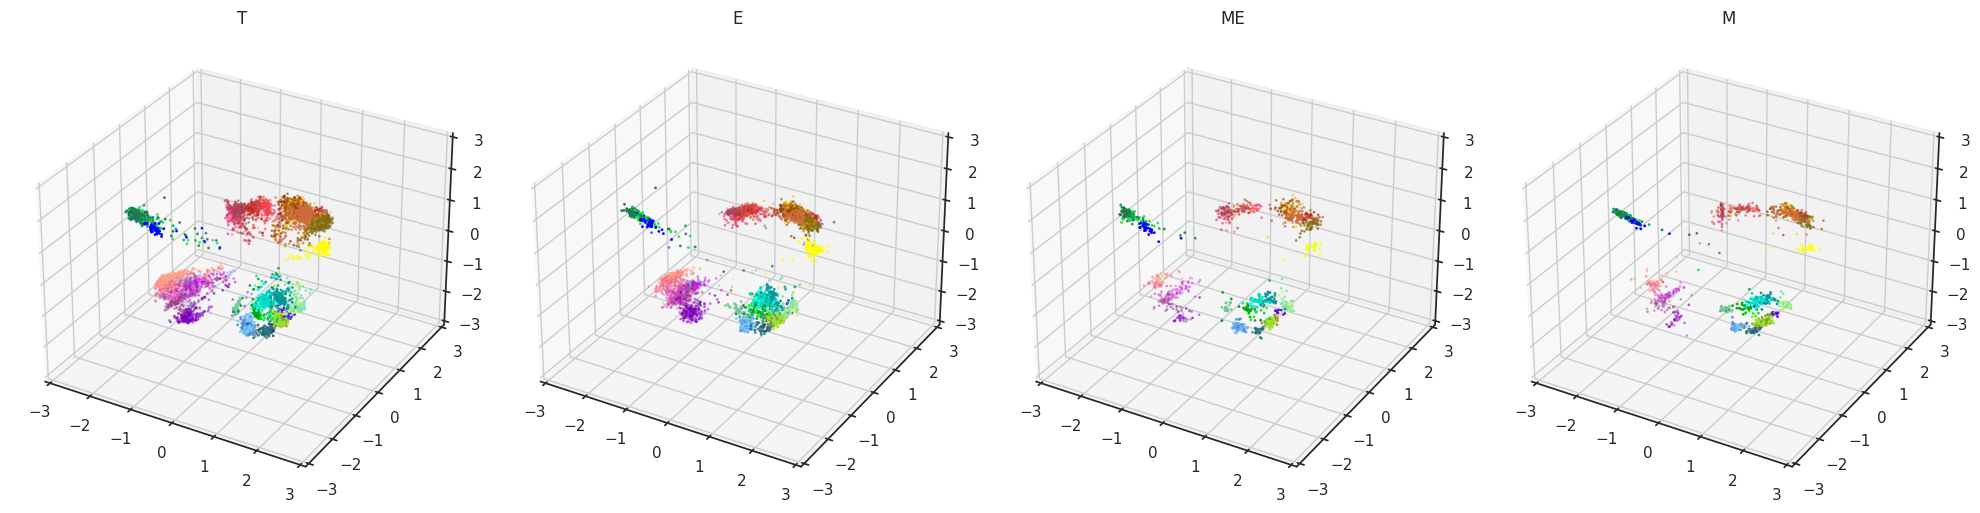

10fold cross_validated Classification acc at different levels:
+----+--------------+----------------+-----------------+----------------+
|    |   t_clusters |   et_class_acc |   met_class_acc |   mt_class_acc |
|----+--------------+----------------+-----------------+----------------|
|  0 |           93 |          43.53 |           50.91 |          43.47 |
|  0 |           59 |          62.62 |           75.49 |          68.86 |
|  0 |           50 |          66.39 |           81.78 |          75.24 |
+----+--------------+----------------+-----------------+----------------+
Leiden communitie silhouette score:
+----+---------------+----------------+-----------------+----------------+
|    |   sil_score_t |   sil_score_et |   sil_score_met |   sil_score_mt |
|----+---------------+----------------+-----------------+----------------|
|  0 |      0.421292 |       0.411986 |         0.52451 |       0.485383 |
+----+---------------+----------------+-----------------+----------------+


In [10]:
output = load_exp_output(exp_name=exp["8000cells_classification_at50"], pkl_file="Results_trial_976.pkl")
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))
# print("Leiden communities:")
# print(tabulate(get_Leiden_comms(output), headers = 'keys', tablefmt = 'psql'))
print("10fold cross_validated Classification acc at different levels:")
print(tabulate(summary_classification_results(output), headers = 'keys', tablefmt = 'psql'))
print("Leiden communitie silhouette score:")
print(tabulate(summary_leiden_comm_silhouette_score(output), headers = 'keys', tablefmt = 'psql'))

#### Optimizing classification acc for ~93 UNmerged t_types and ~8000 cells 

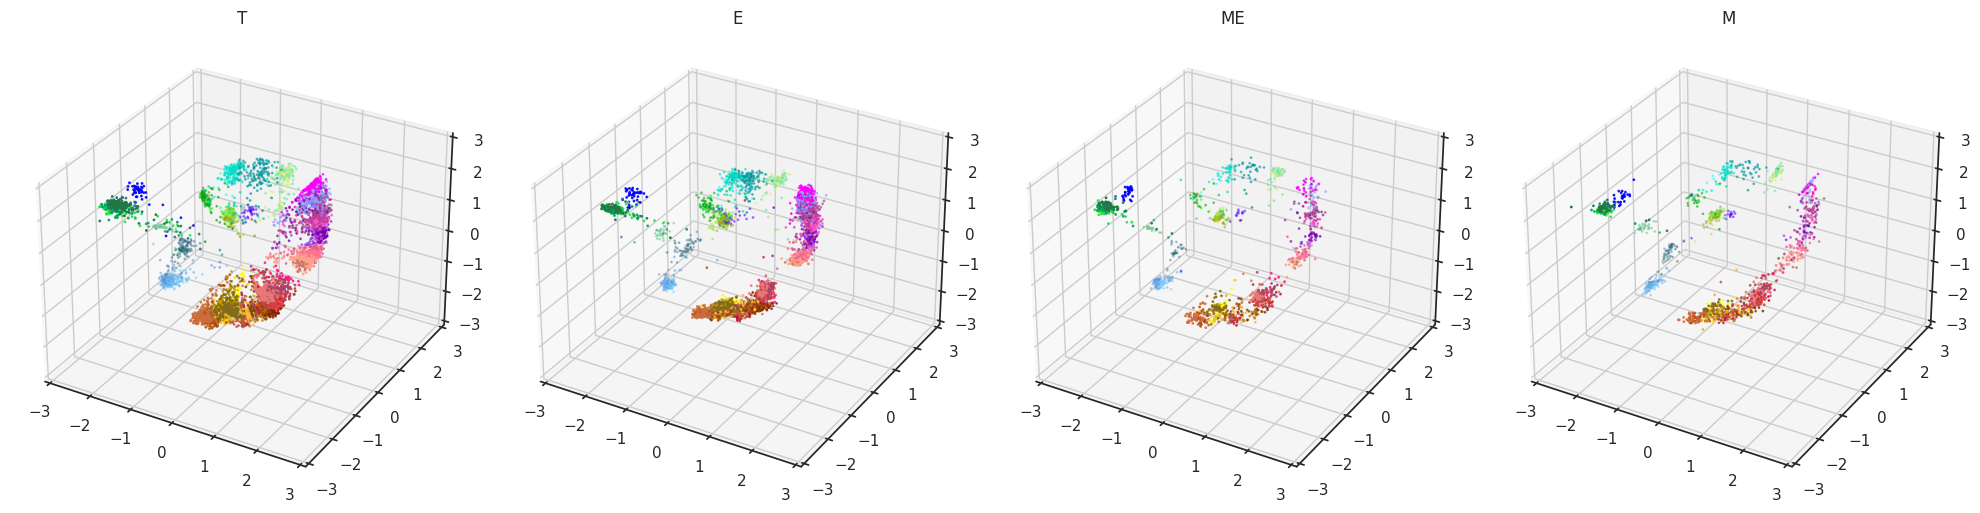

10fold cross_validated Classification acc at different levels:
+----+--------------+----------------+-----------------+----------------+
|    |   t_clusters |   et_class_acc |   met_class_acc |   mt_class_acc |
|----+--------------+----------------+-----------------+----------------|
|  0 |           93 |          47.81 |           57.39 |          46.55 |
+----+--------------+----------------+-----------------+----------------+
Leiden communitie silhouette score:
+----+---------------+----------------+-----------------+----------------+
|    |   sil_score_t |   sil_score_et |   sil_score_met |   sil_score_mt |
|----+---------------+----------------+-----------------+----------------|
|  0 |      0.407654 |       0.473071 |        0.489598 |        0.44588 |
+----+---------------+----------------+-----------------+----------------+


In [11]:
output = load_exp_output(exp_name=exp["8000cells_classification_atleaf"], pkl_file="Results_trial_3425.pkl")
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))
# print("Leiden communities:")
# print(tabulate(get_Leiden_comms(output), headers = 'keys', tablefmt = 'psql'))
df = get_LDA_classification(output, level = "cluster_label")
print("10fold cross_validated Classification acc at different levels:")
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))
print("Leiden communitie silhouette score:")
print(tabulate(summary_leiden_comm_silhouette_score(output), headers = 'keys', tablefmt = 'psql'))

#### Optimizing number of communities for ~8000 cells 

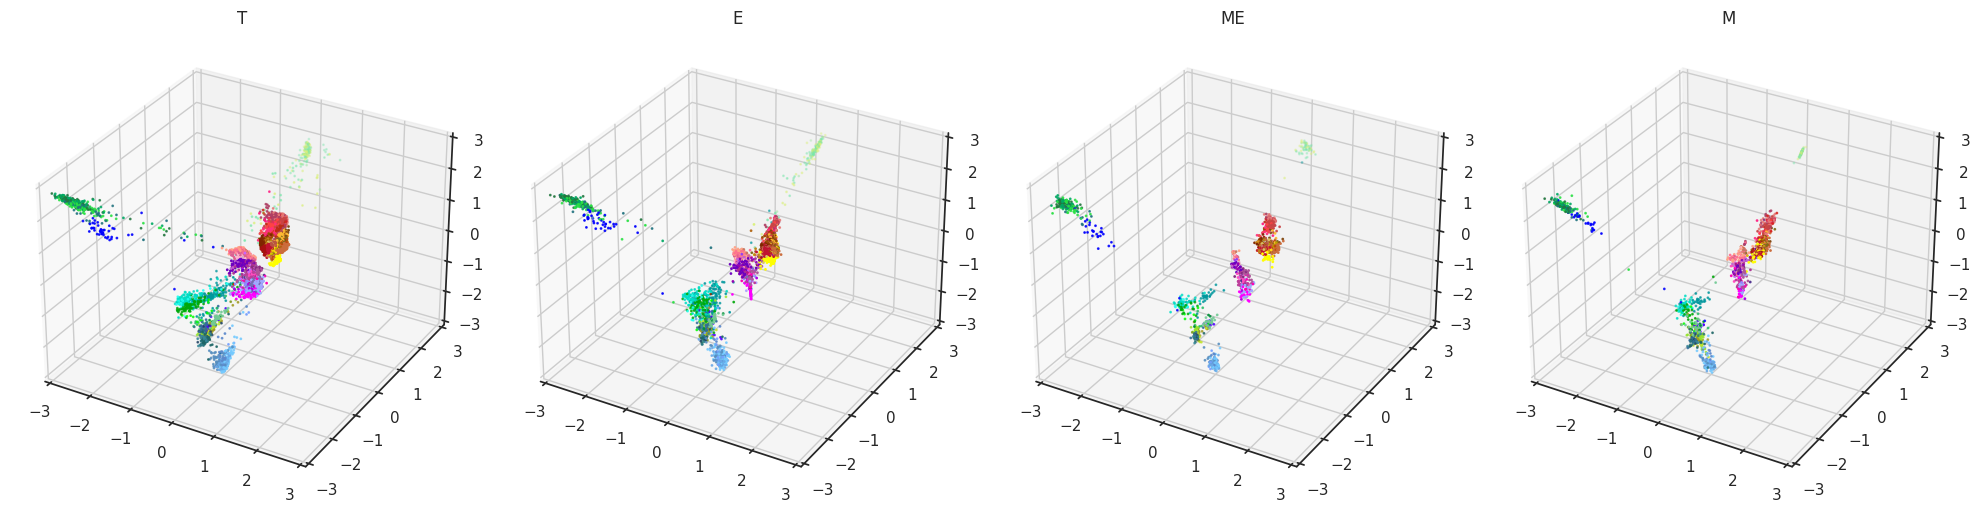

Leiden communities:
+----+----------+-----------+------------+-----------+
|    |   t_comm |   et_comm |   met_comm |   mt_comm |
|----+----------+-----------+------------+-----------|
|  0 |       26 |        24 |         30 |        18 |
+----+----------+-----------+------------+-----------+
Classification acc at different levels:
+----+--------------+----------------+-----------------+----------------+
|    |   t_clusters |   et_class_acc |   met_class_acc |   mt_class_acc |
|----+--------------+----------------+-----------------+----------------|
|  0 |           93 |          30.78 |           38.49 |          30.02 |
+----+--------------+----------------+-----------------+----------------+
Leiden communitie silhouette score:
+----+---------------+----------------+-----------------+----------------+
|    |   sil_score_t |   sil_score_et |   sil_score_met |   sil_score_mt |
|----+---------------+----------------+-----------------+----------------|
|  0 |      0.396491 |       0.333

In [12]:
output = load_exp_output(exp_name=exp["8000cells_community_det"], pkl_file="Results_trial_2159.pkl")
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))
print("Leiden communities:")
print(tabulate(get_Leiden_comms(output), headers = 'keys', tablefmt = 'psql'))
df = get_LDA_classification(output, level = "cluster_label")
print("Classification acc at different levels:")
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))
print("Leiden communitie silhouette score:")
print(tabulate(summary_leiden_comm_silhouette_score(output), headers = 'keys', tablefmt = 'psql'))

### M Reconstructions

In [10]:
val_ind = output['val_ind']
train_ind = output['train_ind']
data_path = "/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat"

filepath = data_path + "/M_arbor_density_103MscaledPC_features_vars_13Mar23.csv"
arbor_density_PC_vars = np.array(pd.read_csv(filepath))[0]
filepath = data_path + "/M_data_13Mar23.mat"
m_input = sio.loadmat(filepath)['hist_ax_de_api_bas']

In [11]:
X_train = m_input[val_ind]
# The ind of the cells that have no arbor densities but have other m features
to_drop = np.where(np.any(np.isnan(X_train.reshape(125,-1)), axis=1))[0]
val_ind = np.delete(val_ind, to_drop)
X_train = m_input[val_ind]

In [12]:
X_train.shape

(125, 120, 4, 4)

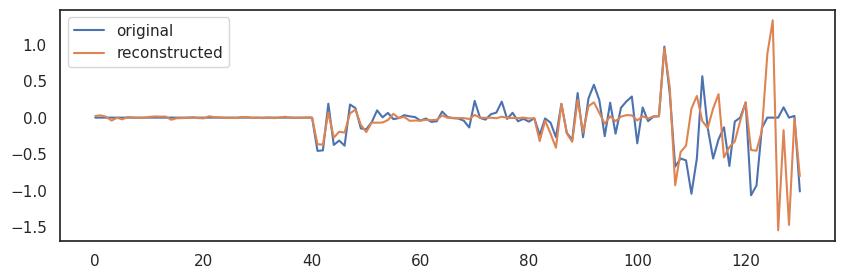

In [13]:
plt.figure(figsize=(10,3))
plt.plot(output['XM'][output['val_ind']][100], label="original")
plt.plot(output['XrM'][output['val_ind']][100], label="reconstructed")
plt.legend()
plt.show()

========================= Original data =============================


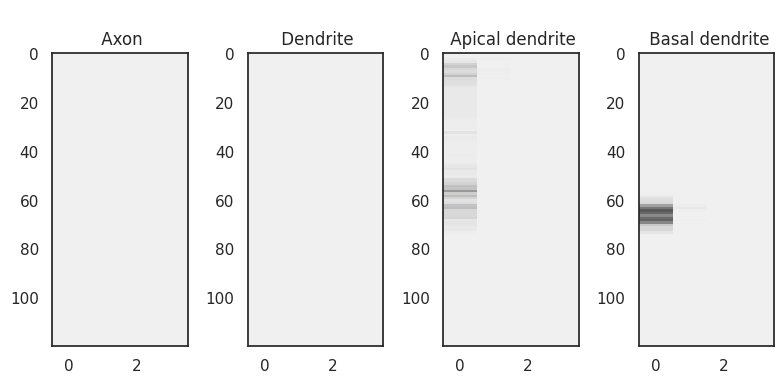

================= reconstructed data from PCs =====================


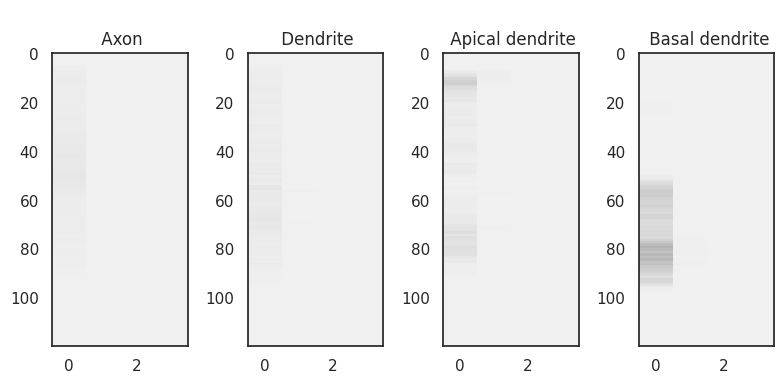

In [15]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(data)

# This is the pc that we used as input to machine (105) i guess 
data_reduced = np.dot(data - pca.mean_, pca.components_.T)
# now to reconstruct the original image from the pcs, we do this. So this must be the size of the (n_sample, 480)
data_original = np.dot(data_reduced, pca.components_) + pca.mean_
# original image is the same as above just we need to reshape them to (n_sample, 120, 4)

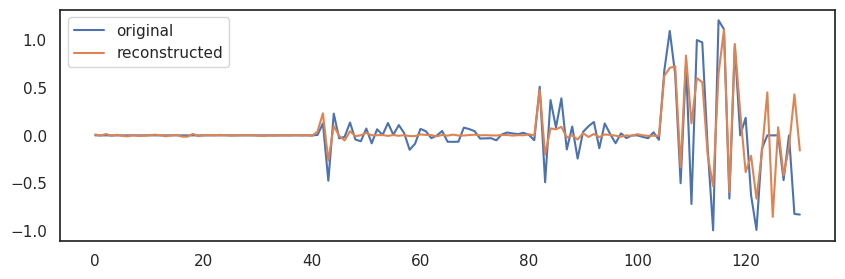

In [16]:
plt.figure(figsize=(10,3))
plt.plot(output['XM'][val_ind][30], label="original")
plt.plot(output['XrM'][val_ind][30], label="reconstructed")
plt.legend()
plt.show()